# Nybsys Recruitment Project

### Importing libaries

In [1]:
import os 
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.6/bin")

from functools import partial
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras import models, layers

### Intialzing Variables

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#AUTOTUNE = 15
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
BUFFER_SIZE = 1000
BATCH_SIZE = 64

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

### Plotting methods

In [3]:
### Plot the confussion matrix of trained model
def plot_cm(labels, predictions):
  cm = tf.math.confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Unmasked image Detected (True Negatives): ', cm[0][0])
  print('Unmasked image Incorrectly Detected (False Positives): ', cm[0][1])
  print('Masked image Missed (False Negatives): ', cm[1][0])
  print('Masked image Detected (True Positives): ', cm[1][1])
  print('Total masked image Transactions: ', np.sum(cm[1]))

### Plot various losses of the model with respect to epochs
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

### Plot various metrices of the model with respect to epochs
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    
### view images from a batch
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

### Parsing methods for dataloaders

In [20]:
### reset the shape of the instaces of the dataset 
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    return img, label
### read , decode and normalize the images
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.image.resize(image_decoded, [120, 120])
    image = tf.cast(image_decoded, tf.float32)
    return image, label
def _parse_function_2(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.image.resize(image_decoded, [120, 120])
    image = tf.cast(image_decoded, tf.float32)
    
    return image.numpy()
### make dataset with given list of filenames and respective lebels
def make_ds(features, labels):
    labels = tf.one_hot(labels,2)
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.map(_parse_function)
    ds = ds.shuffle(BUFFER_SIZE)
    return ds

### Augmentation Function

In [5]:
### Apply augmentation function on a dataset
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

def aug_fn(image, img_size):
    data = {"image":image}
    transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
            ])
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

### Validation and Test Dataset loader

In [6]:
def val_dataloader():
    
    val_files_mask = [f for f in glob.glob("F:/nybsys project/mask_non_mask/mask/val/*/*")]
    val_label = [1]*len(val_files_mask)
    
    val_files_nonmask = [f for f in glob.glob("F:/nybsys project/mask_non_mask/nonmask/val/*/*")]
    val_label = val_label + [0]*len(val_files_nonmask)
    
    val_files = val_files_mask+ val_files_nonmask
    #############################################################################################
    val_label = tf.one_hot(val_label,2)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_files,val_label ))
    
    val_dataset = val_dataset.map(_parse_function)
    val_dataset=  val_dataset.map(set_shapes, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    #############################################################################################
    print(val_dataset)
    print(tf.data.experimental.cardinality(val_dataset).numpy())
    
    return val_dataset

def test_dataloader():

    test_files_mask = [f for f in glob.glob("F:/nybsys project/mask_non_mask/mask/test/*/*")]
    test_label = [1]*len(test_files_mask)
    
    test_files_nonmask = [f for f in glob.glob("F:/nybsys project/mask_non_mask/nonmask/test/*/*")]
    test_label = test_label + [0]*len(test_files_nonmask)
    
    test_files = test_files_mask+ test_files_nonmask
    #############################################################################################
    test_label = tf.one_hot(test_label,2)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_files,test_label )) 
    
    test_dataset = test_dataset.map(_parse_function)
    test_dataset=  test_dataset.map(set_shapes, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    #############################################################################################
    print(test_dataset)
    print(tf.data.experimental.cardinality(test_dataset).numpy())
    
    return test_dataset

### Train Dataloader with Augmentation

In [7]:
def training_dataloader():
    
    train_files_mask = [f for f in glob.glob('F:/nybsys project/mask_non_mask/mask/train/*/*')]
    train_label_mask = [1]*len(train_files_mask)

    train_files_nonmask = [f for f in glob.glob('F:/nybsys project/mask_non_mask/nonmask/train/*/*' )]
    train_label_nonmask = [0]*len(train_files_nonmask)

    pos_ds = make_ds(train_files_mask, train_label_mask)
    ###################################################################################
    """Applying augmentation"""
    aug_1_ds = pos_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    pos_ds = pos_ds.concatenate(aug_1_ds)
    
    aug_2_ds = pos_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    pos_ds = pos_ds.concatenate(aug_2_ds)
    
    aug_3_ds = pos_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    pos_ds = pos_ds.concatenate(aug_3_ds)
    
    aug_4_ds = pos_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    pos_ds = pos_ds.concatenate(aug_4_ds)
    
    aug_5_ds = pos_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    pos_ds = pos_ds.concatenate(aug_5_ds)
    
    aug_6_ds = pos_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    pos_ds = pos_ds.concatenate(aug_6_ds)
    
    print(tf.data.experimental.cardinality(pos_ds).numpy())
    ###################################################################################
    neg_ds = make_ds(train_files_nonmask, train_label_nonmask)
    neg_ds = neg_ds.map(partial(process_data, img_size=120),
                      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    print(tf.data.experimental.cardinality(neg_ds).numpy())
    
    resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.05,0.95])
    
    resampled_ds = resampled_ds.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(AUTOTUNE)
    print(resampled_ds)

    for features, label in resampled_ds.take(1):
        print(label.numpy().mean())


    return resampled_ds
#training_ds()

### Making Classifier

In [8]:
def make_model(input_shape,metrics=METRICS):
    model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(2, activation='sigmoid')])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  loss=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        tf.keras.losses.KLDivergence()],metrics=metrics)
    return model   

### Calling functions to create datasets and model

In [9]:
train_dataset = training_dataloader()
val_dataset = val_dataloader()
test_dataset= test_dataloader()
model= make_model((120,120,3))

16064
14329
<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
0.5
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
80
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
83


### Custom training and validation function

In [10]:
# Train the model
@tf.function
def model_train(features, labels):
    # Define the GradientTape context
    with tf.GradientTape() as tape:
        # Get the probabilities
        predictions = model(features)
        # Calculate the loss
        loss1 = loss_func_1(labels, predictions)
        loss2 = loss_func_2(labels, predictions)
        loss = tf.add(loss1,loss2)
        
    # Get the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update the weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update the loss and accuracy
    train_loss(loss)
    train_acc(labels, predictions)

# Validating the model
@tf.function
def model_validate(features, labels):
    predictions = model(features)
    v_loss = loss_func_1(labels, predictions)

    valid_loss(v_loss)
    valid_acc(labels, predictions)

### Training with augmented train datatset while evaluated with given validation dataset

In [11]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")

# Specify the performance metric
train_acc = tf.keras.metrics.BinaryAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.BinaryAccuracy(name="valid_acc")
loss_func_1 = tf.keras.losses.BinaryCrossentropy()
loss_func_2 = tf.keras.losses.KLDivergence()
optimizer = tf.keras.optimizers.Adam()
print("Training Started")
# Train the model for 2 epochs
for epoch in range(2):
    # Run the model through train and test sets respectively
    for (features, labels) in train_dataset:
        model_train(features, labels)

    for val_features, val_labels in val_dataset:
        model_validate(val_features, val_labels)
        
    # Grab the results
    (loss, acc) = train_loss.result(), train_acc.result()
    (val_loss, val_acc) = valid_loss.result(), valid_acc.result()
    
    # Clear the current state of the metrics
    train_loss.reset_states(), train_acc.reset_states()
    valid_loss.reset_states(), valid_acc.reset_states()
    
    # Local logging
    template = "Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}"
    print (template.format(epoch+1,
                         loss,
                         acc,
                         val_loss,
                         val_acc))

Training Started
Epoch 1, loss: 7.540, acc: 0.730, val_loss: 0.517, val_acc: 0.729
Epoch 2, loss: 0.235, acc: 0.935, val_loss: 0.221, val_acc: 0.942


### Evalaute trained model with test dataset

C:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


83/83 [==============================] - 22s 188ms/step - loss: 0.1608 - tp: 5088.0000 - fp: 365.0000 - tn: 4887.0000 - fn: 164.0000 - accuracy: 0.9496 - precision: 0.9331 - recall: 0.9688 - auc: 0.9865 - prc: 0.9849
Test Confusion Matrix
tf.Tensor(
[[4901  266]
 [  76    9]], shape=(2, 2), dtype=int32)
Unmasked image Detected (True Negatives):  tf.Tensor(4901, shape=(), dtype=int32)
Unmasked image Incorrectly Detected (False Positives):  tf.Tensor(266, shape=(), dtype=int32)
Masked image Missed (False Negatives):  tf.Tensor(76, shape=(), dtype=int32)
Masked image Detected (True Positives):  tf.Tensor(9, shape=(), dtype=int32)
Total masked image Transactions:  85
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5167
           1       0.03      0.11      0.05        85

    accuracy                           0.93      5252
   macro avg       0.51      0.53      0.51      5252
weighted avg       0.97      

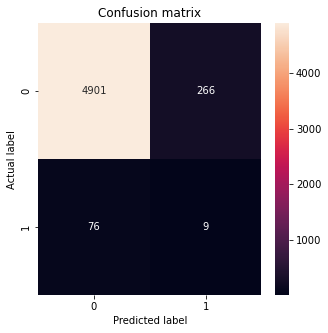

In [12]:
model.evaluate(test_dataset)

y_pred = model.predict(test_dataset)
y_pred = tf.argmax(y_pred, axis = 1)

print('Test Confusion Matrix')
y = np.concatenate([y for x, y in test_dataset], axis=0)
y = tf.argmax(y, axis = 1)
cm =tf.math.confusion_matrix(y, y_pred)
print(cm)
plot_cm(y, y_pred)
import  sklearn
print('Test Classification Report')
print(sklearn.metrics.classification_report(y, y_pred))

In [13]:
file_name =  "model_acc_"+str(cm[1][1])
model_json = model.to_json()
dire = "F:/nybsys project/"+file_name+".json"
dire2 = "F:/nybsys project/"+file_name+".h5"
with open(dire,"w") as json_file:
  json_file.write(model_json)
model.save(dire2) 
#model.save('F:/nybsys project/')

In [26]:
image_path = "F:/nybsys project/corr/1648442725413.jpeg"
image = _parse_function_2(image_path)
#print(image)
image = image.reshape(1,120,120,3)
y_pred = model.predict(image)
print(y_pred)
y_pred = tf.argmax(y_pred, axis = 1)
print(y_pred)

[[1.0000000e+00 2.5934769e-05]]
tf.Tensor([0], shape=(1,), dtype=int64)
